# Lambert Problem Optimisation (e.g. Earth-Mars)

In [1]:
import numpy as np #for array manipulation
import pykep as pk #orbital mechanics package by ESA
#for plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Define the two planets and central body

In [2]:
#using the JPL low-precision ephemeris
p1 = pk.planet.jpl_lp('earth')
p2 = pk.planet.jpl_lp('mars') #try changing to 'jupiter'
#and the central body's gravitational parameter
mu = pk.MU_SUN

## Define departure and arrival intervals

In [3]:
#departure dates
e_d_i = pk.epoch_from_string('2020-03-01 00:00:00.000')
e_d_f = pk.epoch_from_string('2020-11-01 00:00:00.000') #has to be before e_a_i, to always have positive time of flight
#arrival dates
e_a_i = pk.epoch_from_string('2021-01-01 00:00:00.000') #should be changed for other planets
e_a_f = pk.epoch_from_string('2021-10-01 00:00:00.000')
#days between evaluations
delta_d = 1

#Convert epoch object into mjd2000 format (days since year 2000)
#for departure
d_i = e_d_i.mjd2000
d_f = e_d_f.mjd2000
d = np.arange(d_i, d_f, delta_d) #creates vector with mjd2000 days
#now for arrival
a_i = e_a_i.mjd2000
a_f = e_a_f.mjd2000
a = np.arange(a_i, a_f, delta_d) #same as above

#initialize solution 2D array with zeros
S = np.zeros((len(d),len(a)), dtype='int')

## Iterate through the possibilities

In [4]:
#for every departure and arrival dates
for i in range(len(d)):
    for j in range(len(a)):
        #create epochs
        t1 = pk.epoch(d[i])
        t2 = pk.epoch(a[j])
        #determine time of flight
        t = (a[j] - d[i]) * pk.DAY2SEC
        
        #get position and velocity of the planets at respective times
        r1, v1 = p1.eph(t1)
        r2, v2 = p2.eph(t2)
        
        #let pykep solve the lambert problem
        l = pk.lambert_problem(r1, r2, t, mu)
        
        #get the departure and arrival spacecraft velocities
        v1_sc = l.get_v1()[0]
        v2_sc = l.get_v2()[0]
        #subtract to get the ∆v's 
        dv1 = np.subtract(v1_sc, v1)
        dv2 = np.subtract(v2, v2_sc)
        #total ∆v
        tdv = np.linalg.norm(dv1) + np.linalg.norm(dv2)
        
        #save it on the solution matrix
        S[i,j] = tdv

## Check results

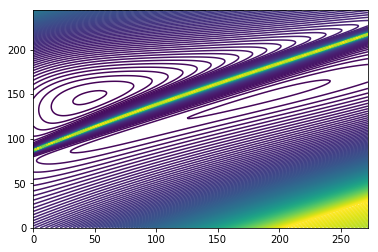

In [5]:
#plot solution matrix as a contour plot
plt.contour(S, 200)

In [6]:
#find minimum value
M = np.min(S)
print(M, 'm/s')

6316 m/s


In [7]:
#and its indices
d_idx = np.where(S == M)[0][0]
a_idx = np.where(S == M)[1][0]

## Recreate the best trajectory

In [8]:
#find the dates from indices
t1 = pk.epoch(d[d_idx])
t2 = pk.epoch(a[a_idx])
#determine flight time
t = (a[a_idx] - d[d_idx]) * pk.DAY2SEC

#get position and velocity of the planets at respective times
r1, v1 = p1.eph(t1)
r2, v2 = p2.eph(t2)
        
#let pykep solve the lambert problem
l = pk.lambert_problem(r1, r2, t, mu)

## Plot Trajectory (and bodies)

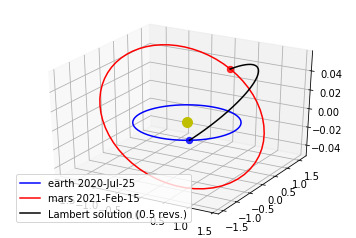

In [9]:
fig = plt.figure()
axis = fig.gca(projection='3d')
pk.orbit_plots.plot_planet(p1, t0=t1, legend=True, units=pk.AU, color='b', ax=axis)
pk.orbit_plots.plot_planet(p2, t0=t2, legend=True, units=pk.AU, color='r', ax=axis)
pk.orbit_plots.plot_lambert(l, color='k', legend=True, units=pk.AU, ax=axis)
axis.scatter([0], [0], [0], color='y', s=100) #plots the sun